ResNet

In [3]:
# Import necessary libraries
# ------------------------------
import torch
print(torch.cuda.is_available())  # # Check if CUDA (GPU support) is available / Should print True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import torch.nn as nn
import torch.nn.functional as F

from tqdm import tqdm # For displaying progress bars during training
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset

from torchsummary import summary

True


In [5]:
# Global hyperparameters
# ------------------------------
Batch_Size=100     # Number of samples per batch
Num_Epoch=2
Learning_Rate=0.01     # Learning rate for optimizer
Criterion=nn.CrossEntropyLoss()    # Loss function for classification
Optimizer=torch.optim.Adam

In [7]:
# Load CIFAR-10 dataset
# ------------------------------
Train_dataset=dsets.CIFAR10(root='./data',train=True,transform=transforms.ToTensor(),download=True)
Test_dataset=dsets.CIFAR10(root='./data',train=False,transform=transforms.ToTensor(),download=True)

Train_loader=DataLoader(dataset=Train_dataset,batch_size=Batch_Size,shuffle=True)
Test_loader=DataLoader(dataset=Test_dataset,batch_size=Batch_Size,shuffle=False)

In [33]:
# BasicBlock for ResNet (used in ResNet18, ResNet34)
# ------------------------------
class BasicBlock(nn.Module):
    expansion = 1  # No expansion for basic block

    def __init__(self, in_channels, planes, stride=1):
        super(BasicBlock, self).__init__()

        # First convolution layer
        self.conv1 = nn.Conv2d(in_channels, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)

        # Second convolution layer
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)


        # Shortcut connection to match dimensions if needed
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)  # Add shortcut (residual connection)
        out = F.relu(out)
        return out


In [22]:
# Bottleneck Block for deeper ResNet (ResNet50, ResNet101, ResNet152)
# ------------------------------
class Bottleneck(nn.Module):
  expansion = 4 # Output channels will be expanded by 4

  def __init__(self, in_planes, planes, stride=1):
    super(Bottleneck, self).__init__()

    # 1x1 conv to reduce dimension
    self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
    self.bn1 = nn.BatchNorm2d(planes)

    # 3x3 conv for feature extraction
    self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
    self.bn2 = nn.BatchNorm2d(planes)

    # 1x1 conv to expand dimension
    self.conv3 = nn.Conv2d(planes, self.expansion*planes, kernel_size=1, bias=False)
    self.bn3 = nn.BatchNorm2d(self.expansion*planes)

    self.shortcut = nn.Sequential()

    if stride != 1 or in_planes != self.expansion*planes:
      self.shortcut = nn.Sequential(
          nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
          nn.BatchNorm2d(self.expansion*planes))

    def forward(self, x):
      out = F.relu(self.bn1(self.conv1(x)))
      out = F.relu(self.bn2(self.conv2(out)))
      out = self.bn3(self.conv3(out))
      out += self.shortcut(x)
      out = F.relu(out)
      return out


In [23]:
# ResNet class that builds the full model using blocks
# ------------------------------
class ResNet(nn.Module):
  def __init__(self, block, num_blocks, num_classes=10):
    super(ResNet, self).__init__()
    self.in_planes = 64

    # Initial conv layer
    self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
    self.bn1 = nn.BatchNorm2d(64)

    # 4 layers of residual blocks
    self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
    self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
    self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
    self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)

    # Fully connected output layer
    self.linear = nn.Linear(512*block.expansion, num_classes)


  # Helper function to create residual layers
  def _make_layer(self, block, planes, num_blocks, stride):
    strides = [stride] + [1]*(num_blocks-1)
    layers = []
    for stride in strides:
      layers.append(block(self.in_planes, planes, stride))
      self.in_planes = planes * block.expansion
    return nn.Sequential(*layers)

  def forward(self, x):
    out = F.relu(self.bn1(self.conv1(x)))
    out = self.layer1(out)
    out = self.layer2(out)
    out = self.layer3(out)
    out = self.layer4(out)
    out = F.avg_pool2d(out, 4) # Global average pooling
    out = out.view(out.size(0), -1) # Flatten
    out = self.linear(out)
    return out

In [28]:
# Training function
# ------------------------------
def fit(model, train_loader):
    model.train()
    running_loss = 0.0
    optimizer = Optimizer(model.parameters(), lr=Learning_Rate)

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = Criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    return avg_loss


In [29]:
# Evaluation function
# ------------------------------
def evaluate(model, test_loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return accuracy


In [30]:
# ResNet Variants
# ------------------------------
def ResNet18():
  return ResNet(BasicBlock, [2,2,2,2])

def ResNet34():
  return ResNet(BasicBlock, [3,4,6,3])

def ResNet50():
  return ResNet(Bottleneck, [3,4,6,3])

def ResNet101():
  return ResNet(Bottleneck, [3,4,23,3])

def ResNet152():
  return ResNet(Bottleneck, [3,8,36,3])

# Test forward pass with dummy input
# ------------------------------
def test():
  net = ResNet18()
  y = net(torch.randn(1, 3, 32, 32))
  print(y.size())

# test()

In [34]:
# Training loop
# ------------------------------
resnet_model = ResNet18().cuda()  # Instantiate and move model to GPU
train_loss4 = []  # To store loss values
test_accuracy4 = [] # To store test accuracy
for epoch in tqdm(range(Num_Epoch)):
    train_loss4.append(fit(resnet_model, Train_loader))
    test_accuracy4.append(evaluate(resnet_model, Test_loader))

100%|██████████| 2/2 [01:41<00:00, 50.74s/it]


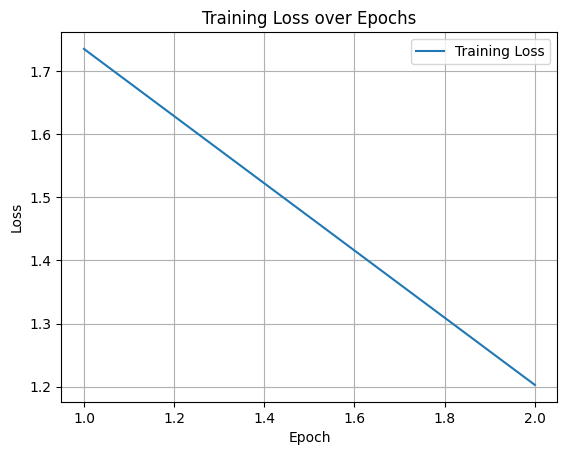

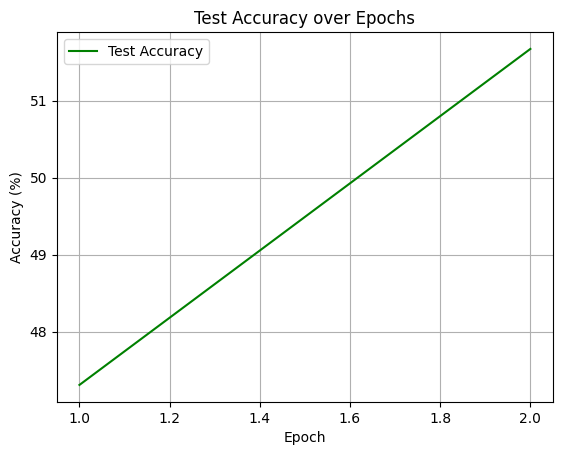

In [35]:
import matplotlib.pyplot as plt

def plot_training_results(train_losses, test_accuracies):
    epochs = range(1, len(train_losses)+1)

    # Plot training loss
    plt.figure()
    plt.plot(epochs, train_losses, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss over Epochs')
    plt.grid(True)
    plt.legend()
    plt.show()

    # Plot test accuracy
    plt.figure()
    plt.plot(epochs, test_accuracies, label='Test Accuracy', color='green')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Test Accuracy over Epochs')
    plt.grid(True)
    plt.legend()
    plt.show()

plot_training_results(train_loss4, test_accuracy4)


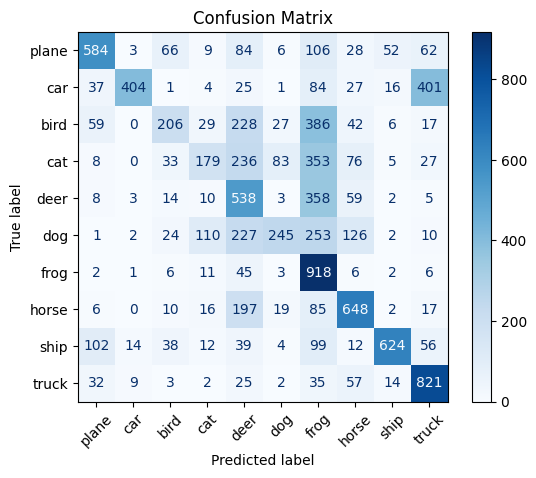

In [36]:
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def show_confusion_matrix(model, dataloader, class_names):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
    plt.title("Confusion Matrix")
    plt.show()

# Class names for CIFAR-10
cifar10_classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Call after training
show_confusion_matrix(resnet_model, Test_loader, cifar10_classes)
